<a href="https://colab.research.google.com/github/AllenHuang03/104947567_concept2/blob/Prediction-Models/predict_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import scipy.sparse
import matplotlib.pyplot as plt
import os
import zipfile
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# Load dataset from Google Drive
data = pd.read_csv('/content/drive/My Drive/UNSW_NB15_testing-set.csv')

In [28]:
# Handle 'state' column
le = LabelEncoder()
data['state_INT'] = le.fit_transform(data['state'])

# Select the specified features
selected_features = ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_state_ttl', 'ct_dst_sport_ltm', 'state_INT']

# Split features and target
X = data[selected_features]
y = data['label']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create preprocessing steps
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [30]:
# Fit the preprocessor and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Print information about the preprocessed features
print("\nPreprocessed Feature Information:")
print(f"Number of samples: {X_train_preprocessed.shape[0]}")
print(f"Number of features after preprocessing: {X_train_preprocessed.shape[1]}")

# Print summary statistics of preprocessed features
print("\nSummary statistics of preprocessed features:")
summary_stats = pd.DataFrame(X_train_preprocessed, columns=selected_features).describe()
print(summary_stats)

# Calculate and print feature correlations
print("\nFeature correlations:")
correlations = pd.DataFrame(X_train_preprocessed, columns=selected_features).corr()
print(correlations)

# Identify highly correlated features
high_correlation_threshold = 0.8
high_correlations = np.where(np.abs(correlations) > high_correlation_threshold)
high_correlations = [(correlations.index[x], correlations.columns[y], correlations.iloc[x, y])
                     for x, y in zip(*high_correlations) if x != y and x < y]

print("\nHighly correlated features (correlation > 0.8):")
for feat1, feat2, corr in high_correlations:
    print(f"{feat1} - {feat2}: {corr:.2f}")


Preprocessed Feature Information:
Number of samples: 57632
Number of features after preprocessing: 19

Summary statistics of preprocessed features:
                dur         dpkts        sbytes        dbytes          rate  \
count  5.763200e+04  5.763200e+04  5.763200e+04  5.763200e+04  5.763200e+04   
mean  -4.530894e-18 -1.183580e-17  3.082240e-20  5.917902e-18  4.586374e-17   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -2.132581e-01 -1.561429e-01 -4.759079e-02 -8.848710e-02 -5.580477e-01   
25%   -2.132564e-01 -1.561429e-01 -4.702898e-02 -8.848710e-02 -5.578530e-01   
50%   -2.100639e-01 -1.378627e-01 -4.440721e-02 -8.724407e-02 -5.402633e-01   
75%   -6.113360e-02 -6.474210e-02 -3.975045e-02 -8.181109e-02  2.933779e-01   
max    1.243816e+01  1.005492e+02  8.956538e+01  1.022690e+02  6.253357e+00   

               sttl          dttl         sload         dload        sinpkt  \
count  5.763200e+04  5.763200e+04  5.763200e+04  5.763200e+0

In [31]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_preprocessed)

KMeans(n_clusters=3, random_state=42)

In [32]:
# Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_forest.fit(X_train_preprocessed)


IsolationForest(contamination=0.1, random_state=42)

In [33]:
# One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=0.1)
ocsvm.fit(X_train_preprocessed)

OneClassSVM(nu=0.1)

Epoch 1/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4074 - val_loss: 0.1162
Epoch 2/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0886 - val_loss: 0.0494
Epoch 3/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0622 - val_loss: 0.0389
Epoch 4/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0423 - val_loss: 0.0306
Epoch 5/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0367 - val_loss: 0.0229
Epoch 6/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0254 - val_loss: 0.0185
Epoch 7/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0220 - val_loss: 0.0210
Epoch 8/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0260 - val_loss: 0.0157
Epoch 9/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0213 - val_loss: 0.0144
Epoch 10/10
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0188 - val_loss: 0.0140


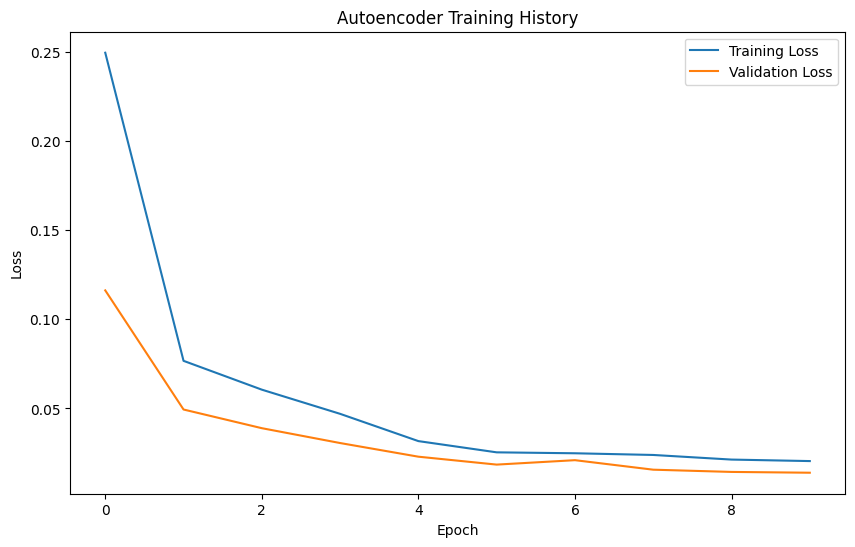

In [34]:
# Autoencoder
input_dim = X_train_preprocessed.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_train_preprocessed, X_train_preprocessed,
                          epochs=10, batch_size=32, shuffle=True,
                          validation_data=(X_val_preprocessed, X_val_preprocessed))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Function to make predictions
def predict_anomalies(data, threshold_percentile=95):
    # Make predictions using different models
    kmeans_pred = kmeans.predict(data)
    if_pred = isolation_forest.predict(data)
    ocsvm_pred = ocsvm.predict(data)

    # Autoencoder reconstruction error
    reconstructed = autoencoder.predict(data)
    mse = np.mean(np.power(data - reconstructed, 2), axis=1)
    threshold = np.percentile(mse, threshold_percentile)
    ae_pred = (mse > threshold).astype(int)

    # Combine predictions (you can adjust this logic based on your requirements)
    final_pred = (if_pred == -1) | (ocsvm_pred == -1) | (ae_pred == 1)

    return final_pred, kmeans_pred

# Evaluate on validation set
val_anomalies, val_clusters = predict_anomalies(X_val_preprocessed)

# Print validation results
print("\nValidation Results:")
print(confusion_matrix(y_val, val_anomalies))
print(classification_report(y_val, val_anomalies))

# Evaluate on test set
test_anomalies, test_clusters = predict_anomalies(X_test_preprocessed)

# Print test results
print("\nTest Results:")
print(confusion_matrix(y_test, test_anomalies))
print(classification_report(y_test, test_anomalies))

# Evaluate clustering performance
kmeans_labels = kmeans.predict(X_test_preprocessed)
silhouette_avg = silhouette_score(X_test_preprocessed, kmeans_labels)
db_score = davies_bouldin_score(X_test_preprocessed, kmeans_labels)
ch_score = calinski_harabasz_score(X_test_preprocessed, kmeans_labels)

print(f"\nClustering Evaluation Metrics:")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Score: {ch_score}")



386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Validation Results:
[[4480 1073]
 [6034  763]]
              precision    recall  f1-score   support

           0       0.43      0.81      0.56      5553
           1       0.42      0.11      0.18      6797

    accuracy                           0.42     12350
   macro avg       0.42      0.46      0.37     12350
weighted avg       0.42      0.42      0.35     12350

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Test Results:
[[4508 1086]
 [5974  782]]
              precision    recall  f1-score   support

           0       0.43      0.81      0.56      5594
           1       0.42      0.12      0.18      6756

    accuracy                           0.43     12350
   macro avg       0.42      0.46      0.37     12350
weighted avg       0.42      0.43      0.35     12350


Clustering Evaluation Metrics:
Silhouette Score: 0.38983605435877405
Davies-Bouldin Score: 1.2875019003253565
Calinski-Harabasz Score: 2214.9255636656026


In [37]:
# Save the models
joblib.dump(selected_features, 'selected_features.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')
joblib.dump(isolation_forest, 'isolation_forest_model.joblib')
joblib.dump(ocsvm, 'ocsvm_model.joblib')
autoencoder.save('autoencoder_model.h5')

# Save the LabelEncoder
joblib.dump(le, 'state_label_encoder.joblib')

print("\nModels have been trained and saved successfully.")

# Zip the saved models and selected features
model_files = ['preprocessor.joblib', 'kmeans_model.joblib', 'isolation_forest_model.joblib',
               'ocsvm_model.joblib', 'autoencoder_model.h5', 'state_label_encoder.joblib',
               'selected_features.joblib']

with zipfile.ZipFile('pred_models.zip', 'w') as zipf:
    for file in model_files:
        zipf.write(file)

print("Models and selected features have been zipped successfully.")

# If you're using Google Colab, use this to download the zip file
files.download('pred_models.zip')

# Optional: List contents of the zip file (for verification)
with zipfile.ZipFile('pred_models.zip', 'r') as zipf:
    print("Contents of the zip file:")
    print(zipf.namelist())




Models have been trained and saved successfully.
Models and selected features have been zipped successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Contents of the zip file:
['preprocessor.joblib', 'kmeans_model.joblib', 'isolation_forest_model.joblib', 'ocsvm_model.joblib', 'autoencoder_model.h5', 'state_label_encoder.joblib', 'selected_features.joblib']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>